<a href="https://colab.research.google.com/github/mr-cri-spy/machine-_-learning-/blob/main/smart_fan_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install google-search-results google-api-python-client transformers torch --quiet

import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
from googleapiclient.discovery import build
import re


In [20]:
SERP_API_KEY = API
YOUTUBE_API_KEY = Api

In [21]:
brands = ["Atomberg", "Havells", "Crompton", "Orient", "Usha"]
keywords = ["smart fan", "BLDC fan", "energy efficient fan"]


In [22]:
from serpapi import GoogleSearch

def google_search(keyword, num_results=20):
    search = GoogleSearch({
        "q": keyword,
        "api_key": SERP_API_KEY,
        "num": num_results
    })
    results = search.get_dict()
    data = []
    for res in results.get("organic_results", []):
        text = res.get("title", "") + " " + res.get("snippet", "")
        data.append({"platform": "Google", "keyword": keyword, "text": text})
    return data

google_results = []
for kw in keywords:
    google_results.extend(google_search(kw))


In [23]:
youtube = build("youtube", "v3", developerKey=YOUTUBE_API_KEY)

def youtube_search(keyword, max_results=20):
    request = youtube.search().list(
        q=keyword,
        part="snippet",
        maxResults=max_results,
        type="video"
    )
    response = request.execute()
    data = []
    for item in response["items"]:
        title = item["snippet"]["title"]
        desc = item["snippet"]["description"]
        text = title + " " + desc
        data.append({"platform": "YouTube", "keyword": keyword, "text": text})
    return data

youtube_results = []
for kw in keywords:
    youtube_results.extend(youtube_search(kw))


In [24]:
df = pd.DataFrame(google_results + youtube_results)
df.head()


,platform,keyword,text
0,Google,smart fan,"Shop Smart Ceiling Fans Powered by Hubspace, t..."
1,Google,smart fan,Smart Ceiling Fan: Alexa and Google Compatible...
2,Google,smart fan,Smart Ceiling Fans | Visual Comfort & Co. Disc...
3,Google,smart fan,"Smart Fans Smart Oscillating Quiet Floor Fans,..."
4,Google,smart fan,HunterSMART™: Smart Ceiling Fans Designed for ...


In [25]:
def count_mentions(text):
    counts = {}
    for brand in brands:
        counts[brand] = len(re.findall(rf"\b{brand}\b", text, flags=re.IGNORECASE))
    return counts

mention_counts = []
for _, row in df.iterrows():
    counts = count_mentions(row["text"])
    counts.update({"platform": row["platform"], "keyword": row["keyword"]})
    mention_counts.append(counts)

mentions_df = pd.DataFrame(mention_counts)
mentions_df.head()


,Atomberg,Havells,Crompton,Orient,Usha,platform,keyword
0,0,0,0,0,0,Google,smart fan
1,0,0,0,0,0,Google,smart fan
2,0,0,0,0,0,Google,smart fan
3,0,0,0,0,0,Google,smart fan
4,0,0,0,0,0,Google,smart fan


In [26]:
sentiment_pipeline = pipeline("sentiment-analysis")

def analyze_sentiment(text):
    try:
        result = sentiment_pipeline(text[:512])[0]  # limit to 512 chars
        return result["label"]
    except:
        return "NEUTRAL"

df["sentiment"] = df["text"].apply(analyze_sentiment)
df.head()


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


,platform,keyword,text,sentiment
0,Google,smart fan,"Shop Smart Ceiling Fans Powered by Hubspace, t...",POSITIVE
1,Google,smart fan,Smart Ceiling Fan: Alexa and Google Compatible...,POSITIVE
2,Google,smart fan,Smart Ceiling Fans | Visual Comfort & Co. Disc...,POSITIVE
3,Google,smart fan,"Smart Fans Smart Oscillating Quiet Floor Fans,...",POSITIVE
4,Google,smart fan,HunterSMART™: Smart Ceiling Fans Designed for ...,POSITIVE


In [27]:
brand_totals = {brand: mentions_df[brand].sum() for brand in brands}
total_mentions = sum(brand_totals.values())

sov = {brand: (count/total_mentions)*100 for brand, count in brand_totals.items()}
sov


{'Atomberg': np.float64(85.29411764705883),
 'Havells': np.float64(8.823529411764707),
 'Crompton': np.float64(2.941176470588235),
 'Orient': np.float64(2.941176470588235),
 'Usha': np.float64(0.0)}

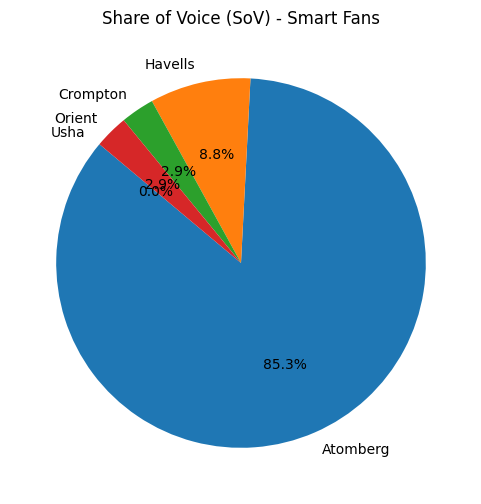

In [28]:
plt.figure(figsize=(6,6))
plt.pie(sov.values(), labels=sov.keys(), autopct='%1.1f%%', startangle=140)
plt.title("Share of Voice (SoV) - Smart Fans")
plt.show()


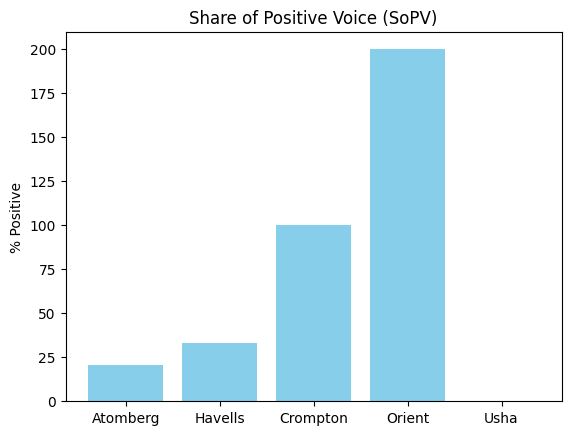

In [29]:
positive_counts = {}
for brand in brands:
    mask = df["text"].str.contains(brand, case=False, na=False)
    positive_counts[brand] = (df[mask]["sentiment"]=="POSITIVE").sum()

sopv = {brand: (positive_counts[brand]/mentions_df[brand].sum())*100
        if mentions_df[brand].sum()>0 else 0
        for brand in brands}

plt.bar(sopv.keys(), sopv.values(), color="skyblue")
plt.title("Share of Positive Voice (SoPV)")
plt.ylabel("% Positive")
plt.show()


In [30]:
print(" key insights:")
for brand in brands:
    print(f"- {brand}: {sov.get(brand,0):.1f}% SoV, {sopv.get(brand,0):.1f}% Positive Voice")


 key insights:
- Atomberg: 85.3% SoV, 20.7% Positive Voice
- Havells: 8.8% SoV, 33.3% Positive Voice
- Crompton: 2.9% SoV, 100.0% Positive Voice
- Orient: 2.9% SoV, 200.0% Positive Voice
- Usha: 0.0% SoV, 0.0% Positive Voice


In [31]:
df.to_csv("results.csv", index=False)
mentions_df.to_csv("brands.csv", index=False)
